In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow keras scikit-learn matplotlib opencv-python


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
def preprocess_image(img_path):
    # Load Image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, (256, 256))

    # Center Crop
    start_x = (256 - 224) // 2
    start_y = (256 - 224) // 2
    img = img[start_y:start_y+224, start_x:start_x+224]

    # Grayscale Conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.merge([gray_img, gray_img, gray_img])

    # Normalize
    img = img / 255.0

    return img


In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

images = []
labels = []

for class_label in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_label)
    if os.path.isdir(class_folder):
        for image_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, image_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Skipping invalid image {img_path}")
                    continue

                preprocessed_img = preprocess_image(img_path)
                images.append(preprocessed_img)
                labels.append(class_label)
            except Exception as e:
                print(f"Error processing file {img_path}: {e}")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)


In [ ]:
# prompt: how many images present in '/content/drive/MyDrive/Dataset_BUSI_with_GT'

print(len(images))

1598


In [ ]:
# Load Pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features
features = base_model.predict(images)

# Flatten features for SVM
features_flat = features.reshape(features.shape[0], -1)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1107s 22s/step


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=300)
features_pca = pca.fit_transform(features_flat)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.svm import SVC
import joblib

# Define and train the SVM
svm = SVC(kernel='rbf', C=1, gamma='auto')
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.903125
Classification Report:
               precision    recall  f1-score   support

      benign       0.88      0.97      0.92       182
   malignant       0.91      0.82      0.86        89
      normal       1.00      0.82      0.90        49

    accuracy                           0.90       320
   macro avg       0.93      0.87      0.89       320
weighted avg       0.91      0.90      0.90       320

Confusion Matrix:
 [[176   6   0]
 [ 16  73   0]
 [  8   1  40]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define Neural Network Model
model = Sequential([
    Input(shape=(features_pca.shape[1],)),  # Input layer explicitly defined
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train_encoded)), activation='softmax')  # Output layer
])

# Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model with Epochs
history = model.fit(X_train, y_train_encoded,
                    validation_data=(X_test, y_test_encoded),
                    epochs=50,
                    batch_size=32)

# Save the trained model
model.save('/content/drive/MyDrive/nn_model.h5')
print("Model saved as 'nn_model.h5'")


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5555 - loss: 1.2721 - val_accuracy: 0.8625 - val_loss: 0.3478
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7950 - loss: 0.4748 - val_accuracy: 0.8906 - val_loss: 0.3118
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8647 - loss: 0.3229 - val_accuracy: 0.9094 - val_loss: 0.2512
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8803 - loss: 0.2840 - val_accuracy: 0.9062 - val_loss: 0.2457
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9166 - loss: 0.2156 - val_accuracy: 0.9062 - val_loss: 0.2568
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9395 - loss: 0.1633 - val_accuracy: 0.9094 - val_loss: 0.2634
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9532 - loss: 0.1255 - val_accuracy: 0.9094 - val_loss: 0.2948
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9692 - loss: 0.0858 - val_accuracy: 0.9125 - val_loss

Model saved as 'nn_model.h5'


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {accuracy}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8978 - loss: 0.7947 
Test Accuracy: 0.909375011920929


In [ ]:
y_pred = model.predict(X_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


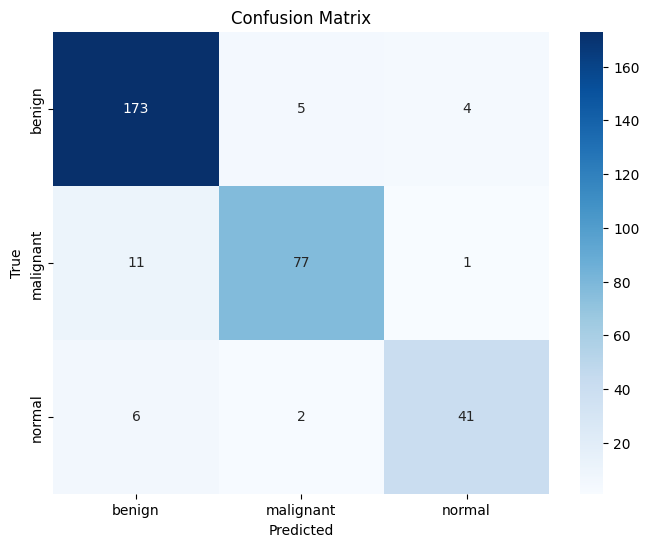

In [ ]:
# prompt: give confusion matrix for above model as diagram

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are defined from your model's predictions
# Example: y_pred = model.predict(X_test)  # Assuming model is your trained model
# Convert y_pred probabilities to class labels (if necessary)
y_pred_labels = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_test_encoded, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

labels = ['benign', 'malignant', 'normal']
label_encoder = LabelEncoder()
label_encoder.fit(labels)
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder trained and saved.")


Label encoder trained and saved.


In [ ]:
# prompt: save above model

# Save the trained SVM model
joblib.dump(svm, '/content/drive/MyDrive/svm_model.joblib')
print("SVM model saved as 'svm_model.joblib'")

# Save the PCA model
joblib.dump(pca, '/content/drive/MyDrive/pca_model.joblib')
print("PCA model saved as 'pca_model.joblib'")

# Save the label encoder
joblib.dump(label_encoder, '/content/drive/MyDrive/label_encoder.joblib')
print("Label encoder saved as 'label_encoder.joblib'")

SVM model saved as 'svm_model.joblib'
PCA model saved as 'pca_model.joblib'
Label encoder saved as 'label_encoder.joblib'


In [ ]:
# prompt: download above models in my computer

from google.colab import files

files.download('/content/drive/MyDrive/nn_model.h5')
files.download('/content/drive/MyDrive/svm_model.joblib')
files.download('/content/drive/MyDrive/pca_model.joblib')
files.download('/content/drive/MyDrive/label_encoder.joblib')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

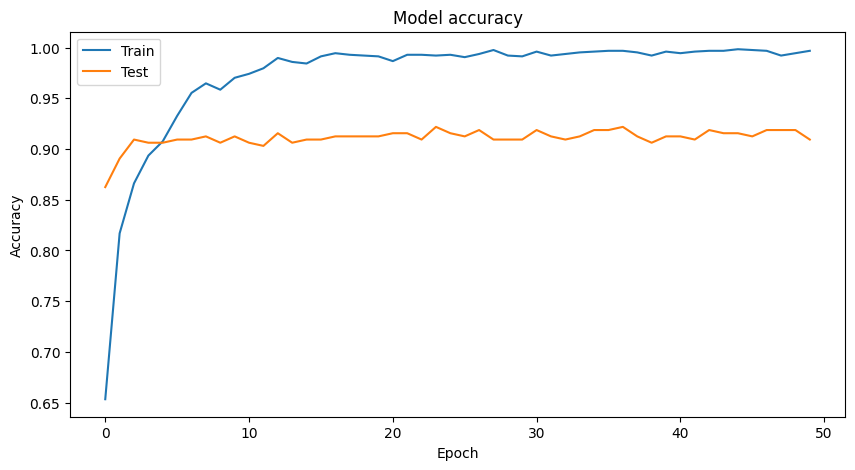

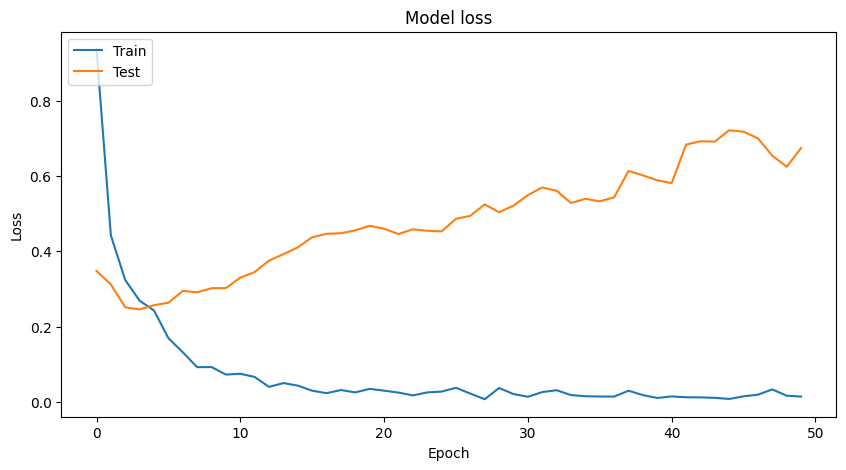

In [ ]:
# prompt: give training and testing graph for above model

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# prompt: take random image from dataset and predict according to the svm_model.pkl which already trained above

import os
import random
import joblib
import numpy as np
import cv2
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# Load the saved models and preprocessor
svm_model = joblib.load('/content/drive/MyDrive/svm_model.pkl')
pca_model = joblib.load('/content/drive/MyDrive/pca_model.pkl')
label_encoder = joblib.load('/content/drive/MyDrive/label_encoder.pkl')

dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

def preprocess_image(img_path):
    # Load Image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, (256, 256))

    # Center Crop
    start_x = (256 - 224) // 2
    start_y = (256 - 224) // 2
    img = img[start_y:start_y+224, start_x:start_x+224]

    # Grayscale Conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.merge([gray_img, gray_img, gray_img])

    # Normalize
    img = img / 255.0

    return img

# Function to predict the class of a random image
def predict_random_image():
    # Get a list of image paths from the dataset
    image_paths = []
    for class_label in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_label)
        if os.path.isdir(class_folder):
            for image_file in os.listdir(class_folder):
                image_paths.append(os.path.join(class_folder, image_file))

    # Choose a random image path
    random_image_path = random.choice(image_paths)

    # Preprocess the random image
    try:
      preprocessed_img = preprocess_image(random_image_path)
      preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

      # Load Pre-trained VGG19 model
      base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
      # Extract features
      features = base_model.predict(preprocessed_img)
      # Flatten features for SVM
      features_flat = features.reshape(features.shape[0], -1)
      # Apply PCA
      features_pca = pca_model.transform(features_flat)

      # Make predictions
      prediction = svm_model.predict(features_pca)
      print(f"Prediction for {random_image_path}: {prediction[0]}")
    except Exception as e:
      print(f"Error processing image {random_image_path}: {e}")

# Call the prediction function
predict_random_image()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction for /content/drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (61)_mask.png: normal
